In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# load the sales data set
sales_data = pd.read_csv('../../../../Data/SalesData.csv')
sales_data.head()

sales_data = sales_data[sales_data['Category'] == 'Dermafiller'] 


pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Pharmacy 1,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
2,1-11-2015,11,4,2015,1,Injection 1,Dermafiller,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
3,1-11-2015,11,4,2015,1,Injection 2,Dermafiller,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
5,1-12-2015,12,4,2015,8,Injection 3,Dermafiller,Pharmacy 1,"Scotland, Newcastle",1,...,0,0,0,0,0,0,0,1,0,0
6,1-12-2015,12,4,2015,4,Injection 2,Dermafiller,Pharmacy 1,"Scotland, Newcastle",1,...,0,0,0,0,0,0,0,1,0,0
7,1-12-2015,12,4,2015,8,Injection 1,Dermafiller,Pharmacy 1,"Scotland, Newcastle",1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68232,1-3-2022,3,1,2022,1,Injection 5,Dermafiller,Pharmacy 5,SouthWest,0,...,0,0,0,0,0,0,0,0,0,1
68233,1-3-2022,3,1,2022,2,Injection 6,Dermafiller,Pharmacy 5,SouthEast,0,...,0,0,0,0,0,0,0,0,1,0
68234,1-3-2022,3,1,2022,13,Injection 6,Dermafiller,Pharmacy 5,NorthWest,0,...,0,0,0,0,1,0,0,0,0,0
68235,1-3-2022,3,1,2022,13,Injection 6,Dermafiller,Pharmacy 5,SouthWest,0,...,0,0,0,0,0,0,0,0,0,1


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Pharmacy 1',
 'Pharmacy 10',
 'Pharmacy 11',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 4',
 'Pharmacy 5',
 'Pharmacy 6',
 'Pharmacy 7',
 'Pharmacy 8',
 'Pharmacy 9',
 'Injection 1',
 'Injection 2',
 'Injection 3',
 'Injection 4',
 'Injection 5',
 'Injection 6',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Pharmacy 1' : 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 4' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 6' : 'sum',
    'Pharmacy 7' : 'sum',
    'Pharmacy 8' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Pharmacy 11' : 'sum',
    'Injection 1' :'sum',
    'Injection 2' :'sum',
    'Injection 3' :'sum',
    'Injection 4' :'sum',
    'Injection 5' :'sum',
    'Injection 6' :'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

# print(sales_data_lagged)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)

sales_data_lagged['Date'] = pd.to_datetime(sales_data_lagged['Date'], format='%d-%m-%Y')


#X_train, X_test, y_train, y_test = train_test_split(sales_data_lagged.loc[:,sales_data_lagged.columns!='Qty'], sales_data_lagged.loc[:,['Date', 'Qty']], test_size=0.2, random_state=42)
X = sales_data_lagged.loc[(sales_data_lagged['Date'] < '2021-12-01')]
y = sales_data_lagged.loc[(sales_data_lagged['Date'] >= '2021-12-01')]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X.loc[:,X.columns!='Qty']
X_test = y.loc[:,y.columns!='Qty']
y_train = X.loc[:,X.columns=='Qty']
y_test = y.loc[:,y.columns=='Qty']



In [4]:
y

,Date,Qty,Pharmacy 1,Pharmacy 2,Pharmacy 3,Pharmacy 4,Pharmacy 5,Pharmacy 6,Pharmacy 7,Pharmacy 8,...,"Scotland, Newcastle",SouthEast,SouthWest,Qty_lag_1,Qty_lag_2,Qty_lag_3,Qty_lag_4,Qty_lag_5,Qty_lag_6,Qty_lag_7
26,2021-12-01,623,4,97,2,6,24,1,3,5,...,33,1,8,737.0,555.0,560.0,175.0,70.0,25.0,740.0
33,2022-02-01,711,7,92,7,0,33,3,12,13,...,48,18,21,122.0,746.0,646.0,270.0,56.0,37.0,623.0
40,2022-03-01,883,14,88,15,0,32,0,6,7,...,45,9,13,521.0,519.0,581.0,308.0,119.0,112.0,711.0


In [5]:
# train a random forest model

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

criterion = ['friedman_mse', 'squared_error']
max_depth = [5, 10]
min_samples_leaf = [1, 2]
max_features = ['log2', 'sqrt']
loss = ['squared_error', 'huber', 'quantile']

random_grid_gbr = {
    'criterion' : criterion,
    'max_depth' : max_depth,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features,
    'loss' : loss
}

gbr = GradientBoostingRegressor()
# gbr_random = RandomizedSearchCV(
#     estimator=gbr,
#     param_distributions=random_grid_gbr,
#     n_iter=10,
#     cv=5,
#     verbose=5,
#     random_state=0
# )

gbr_random = GridSearchCV(
    estimator=gbr,
    param_grid = random_grid_gbr,
    cv=5,
    verbose=5
)

In [6]:
gbr_random.fit(X_train.iloc[:, 2:], y_train['Qty'])


# make predictions for the test data
predictions = gbr_random.predict(X_test.iloc[:, 2:])

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.947 total time=   0.2s
[CV 2/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.977 total time=   0.1s
[CV 3/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.942 total time=   0.2s
[CV 4/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.832 total time=   0.5s
[CV 5/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.979 total time=   0.2s
[CV 1/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2;, score=0.948 total time=   0.2s
[CV 2/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min

In [7]:
# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - y_test['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

# calculate the mean squared error
mse = mean_squared_error(y_test['Qty'], predictions)
print('MSE:', mse)

# calculate the r2 score
r2_score = r2_score(y_test['Qty'], predictions)
print('R^2 Score:', r2_score)

# calculate explained variance score
explained_variance_score = explained_variance_score(y_test['Qty'], predictions)
print('Explained Variance Score:', explained_variance_score)

# calculate max error
max_error = max_error(y_test['Qty'], predictions)
print('Max Error:', max_error)


print([X_test['Date'].values, y_test['Qty'].values, predictions])

RMSE: 126.65880974940518
MSE: 16042.454087136017
R^2 Score: -0.3760110436129933
Explained Variance Score: 0.5195830241323616
Max Error: 207.961980070521
[array(['2021-12-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000'], dtype='datetime64[ns]'), array([623, 711, 883], dtype=int64), array([570.59315379, 664.81883959, 675.03801993])]


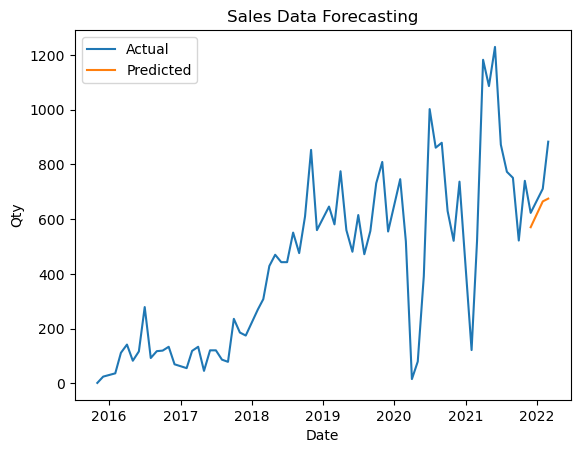

In [8]:
sales_data_lagged['predicted_quantity'] = pd.Series(predictions, index=y_test.index)
sales_data_lagged= sales_data_lagged.sort_values(by=['Date'])

# plot the actual and predicted quantities against date
plt.plot(sales_data_lagged['Date'], sales_data_lagged['Qty'], label='Actual')
plt.plot(sales_data_lagged['Date'], sales_data_lagged['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [9]:
gbr_random.best_params_

{'criterion': 'squared_error',
 'loss': 'squared_error',
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 2}

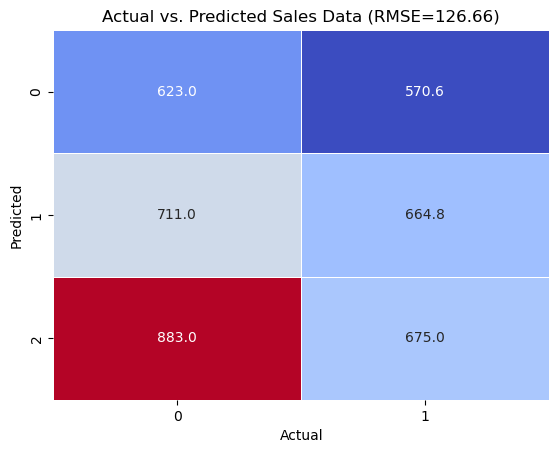

In [10]:
matrix_data = np.column_stack((y_test['Qty'].values, predictions))

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()